<a href="https://colab.research.google.com/github/Mahantesh-Pattadkal-1993/CounterFactuals_GANs/blob/main/MNIST_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aim : The intention of this notebook is to create the MNIST Classifer which uses CNN to classify the images into specific digits. This classifer will be used to explain the counterfactuals images of the instances

In [1]:
#Import the libraries 
import torch
import torch.optim as opt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
mb_size = 64

transform = transforms.Compose(
		[transforms.ToTensor(),
		 transforms.Normalize((0.5,), (0.5,))])

trainData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=True)

trainLoader = torch.utils.data.DataLoader(trainData, shuffle=True, batch_size=mb_size)




Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
testData = torchvision.datasets.MNIST('./data/', download=True, transform=transform, train=False)

testLoader = torch.utils.data.DataLoader(testData, shuffle=True, batch_size=mb_size)

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output


In [19]:
class Net_logits(nn.Module):
    def __init__(self):
        super(Net_logits, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        
        return output , x

In [20]:
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
#model = Generator(nc=1,nz=100,ngf=28).to(device)
#input for Generator = (bs,100,1,1)

model = Net_logits().to(device)
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
           Dropout-3           [-1, 64, 12, 12]               0
            Linear-4                  [-1, 128]       1,179,776
           Dropout-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 1,199,882
Trainable params: 1,199,882
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.52
Params size (MB): 4.58
Estimated Total Size (MB): 5.10
----------------------------------------------------------------


In [21]:

criterion = nn.CrossEntropyLoss()

images, labels = next(iter(trainLoader))
images, labels = images.cuda(), labels.cuda() # add this line
print(images.shape)

model = Net_logits().to(device)

softmax, logits = model(images) #log probabilities
loss = criterion(softmax, labels) #calculate the NLL loss
print(loss)

torch.Size([64, 1, 28, 28])
tensor(2.3011, device='cuda:0', grad_fn=<NllLossBackward>)


In [23]:
optimizer = opt.SGD(model.parameters(), lr=0.003, momentum=0.9)
model.train()

epochs = 25
for e in range(epochs):
    running_loss = 0
    for images, labels in trainLoader:
        images, labels = images.cuda(), labels.cuda() # add this line

        # Flatten MNIST images into a 784 long vector
        #images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output, logits = model(images)
        loss = criterion(logits, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainLoader)))


Epoch 0 - Training loss: 0.1289606428236516
Epoch 1 - Training loss: 0.09363741369899124
Epoch 2 - Training loss: 0.08054533977109168
Epoch 3 - Training loss: 0.07275224948969128
Epoch 4 - Training loss: 0.06589480808654082
Epoch 5 - Training loss: 0.05854395793444082
Epoch 6 - Training loss: 0.05221783510793541
Epoch 7 - Training loss: 0.05128319307452819
Epoch 8 - Training loss: 0.0460883591449194
Epoch 9 - Training loss: 0.04401897547281544
Epoch 10 - Training loss: 0.041673411275503405
Epoch 11 - Training loss: 0.0401965947759371
Epoch 12 - Training loss: 0.038607924055037046
Epoch 13 - Training loss: 0.03341246478035917
Epoch 14 - Training loss: 0.033763119564287424
Epoch 15 - Training loss: 0.03262542902657301
Epoch 16 - Training loss: 0.03047589677405099
Epoch 17 - Training loss: 0.029658424090653626
Epoch 18 - Training loss: 0.02791286877992286
Epoch 19 - Training loss: 0.027999489589955216
Epoch 20 - Training loss: 0.02556001979953155
Epoch 21 - Training loss: 0.02573189160604

In [25]:
model.eval()


for images, labels in testLoader:
    images, labels = images.cuda(), labels.cuda() # add this line

    # Flatten MNIST images into a 784 long vector
    #images = images.view(images.shape[0], -1)

    # Training pass
    #optimizer.zero_grad()
    
    output, logits = model(images)
    loss = criterion(logits, labels)
    
    #This is where the model learns by backpropagating
    #loss.backward()
    
    #And optimizes its weights here
    #optimizer.step()
    
    
    print("Test loss: {}".format( loss/len(testLoader)))

    


Test loss: 0.0002618887519929558
Test loss: 2.0959527319064364e-05
Test loss: 1.0653126992110629e-05
Test loss: 0.0002865306450985372
Test loss: 4.629607246897649e-06
Test loss: 5.717557723983191e-05
Test loss: 0.0005927718011662364
Test loss: 0.00012817887181881815
Test loss: 0.0005612976965494454
Test loss: 2.685259642021265e-05
Test loss: 1.8271188309881836e-05
Test loss: 0.00023353256983682513
Test loss: 2.5148774511762895e-06
Test loss: 2.9379400530160638e-06
Test loss: 3.133785503450781e-05
Test loss: 5.356207566364901e-06
Test loss: 7.572844424430514e-06
Test loss: 2.7425952794146724e-05
Test loss: 0.0005745754460804164
Test loss: 7.65832228353247e-05
Test loss: 4.8644553316989914e-05
Test loss: 3.322844349895604e-05
Test loss: 1.1071354037994752e-06
Test loss: 1.1555080163816456e-05
Test loss: 0.0005792220472358167
Test loss: 2.3892629542388022e-05
Test loss: 7.935428584460169e-06
Test loss: 5.011589109926717e-06
Test loss: 7.167064268287504e-06
Test loss: 2.8640053642448038e-0

In [26]:
dataIter = iter(trainLoader)

imgs, labels = dataIter.next()
imgs,lables = imgs.cuda(), labels.cuda()
labels

tensor([6, 4, 3, 1, 3, 9, 9, 5, 9, 7, 2, 1, 8, 7, 7, 0, 4, 6, 4, 8, 2, 3, 6, 2,
        1, 7, 5, 0, 1, 7, 7, 6, 4, 5, 3, 0, 8, 2, 4, 6, 5, 9, 2, 0, 4, 9, 2, 9,
        7, 4, 0, 6, 0, 0, 4, 4, 3, 9, 2, 0, 2, 1, 4, 4])

In [28]:

pred, logits = model(imgs)
pred_argmax = torch.argmax(pred,dim = 1)
pred_argmax

tensor([6, 4, 3, 1, 3, 9, 9, 5, 9, 7, 2, 1, 8, 7, 7, 0, 4, 6, 4, 8, 2, 3, 6, 2,
        1, 7, 5, 0, 1, 7, 7, 6, 4, 5, 3, 0, 8, 2, 4, 6, 5, 9, 2, 0, 4, 9, 2, 9,
        7, 4, 0, 6, 0, 0, 4, 4, 3, 9, 2, 0, 2, 1, 4, 4], device='cuda:0')

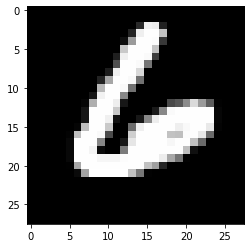

In [15]:
samples = imgs.detach().cpu()

npimgs = samples[1].numpy()
#print(npimgs.shape)

plt.imshow(npimgs[0],cmap='Greys_r')

In [16]:
pred[1]

tensor([  3.2166,  -2.4761,  -0.8830, -12.5160,   8.0146,   1.9995,  26.5229,
        -14.2325,  -3.9779, -10.7414], device='cuda:0',
       grad_fn=<SelectBackward>)

In [17]:
torch.argmax(pred[1])

tensor(6, device='cuda:0')

In [29]:
#Writing the checkpoint of the model 

G_checkpoint = {'model': model,
          'state_dict': model.state_dict()}


PATH = "/content/" + "Classifier_CNN_logits.pth"
torch.save(G_checkpoint, PATH)
